# Libraries 

In [1]:
#Create Dataframe
import re
import seaborn as sns
import os 
import matplotlib.pyplot as plt

#Feature Extraction
import pandas as pd
import numpy as np
import mahotas
from itertools import product
import time
import cv2
from skimage import color
from sklearn.preprocessing import normalize
from scipy.stats import skew, kurtosis
import mahotas.features
from scipy.special import legendre
from datetime import datetime

#Normalization and Onehot Encoding
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

#Train Test Split
from sklearn.model_selection import train_test_split

#SVM Classifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score
from IPython.display import display

In [2]:
def find_nan_rows_columns(dataframe):
    # Find rows with NaN values
    nan_rows = dataframe[dataframe.isnull().any(axis=1)].index.tolist()

    # Find columns with NaN values
    nan_columns = dataframe.columns[dataframe.isnull().any()].tolist()
    
    print(np.shape(dataframe))

    return nan_rows, nan_columns

# Create Dataframe

3 columns
1. Disease Classification
2. Image Name
3. Image RGB Values (RGB Converted from BGR)

In [3]:
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

def create_dataframe_from_folders(root_folder):
    # Initialize empty lists to store data for each column
    folder_names = []
    photo_names = []
    photos = []

    # Find folder path
    for folder_name in sorted(os.listdir(root_folder)):
        folder_path = os.path.join(root_folder, folder_name)

        # Check if the entry in the root folder is a directory
        if os.path.isdir(folder_path):
            for photo_name in sorted(os.listdir(folder_path), key=natural_sort_key):
                # Assuming photos are in common image formats (e.g., jpg, png)
                if photo_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    photo_path = os.path.join(folder_path, photo_name)

                    # Read image data using cv2
                    image_data = cv2.imread(photo_path)

                    # Convert BGR to RGB
                    image_data_rgb = cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB)

                    # Append data to the lists
                    folder_names.append(folder_name)
                    photo_names.append(photo_name)
                    photos.append(image_data_rgb)

    # Create a DataFrame
    df = pd.DataFrame({
        'class': folder_names,
        'img_name': photo_names,
        'rgb': photos
    })

    return df

**Create Datasets** 

In [4]:
# Complete Data
folder_path = r"C:\Users\isabe\Documents\Python Projects\AI 201\Mini Project\resized_raw_images"
complete_df = create_dataframe_from_folders(folder_path)

folder_path = r"C:\Users\isabe\Documents\Python Projects\AI 201\Mini Project\zoomed_resized_data"
zoom_df = create_dataframe_from_folders(folder_path)

folder_path = r"C:\Users\isabe\Documents\Python Projects\AI 201\Mini Project\three_classes"
three_df = create_dataframe_from_folders(folder_path)

**Class Counts**

In [5]:
def count_and_plot_pdf(dataframe, column_name):
    # Get the value counts
    class_counts = dataframe[column_name].value_counts()

    # Plot the PDF with a monochromatic color
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=class_counts.index, y=class_counts.values, color="#007FFF")  
    ax.set(xlabel=f"{column_name}", ylabel="Count", title=f"PDF of {column_name} Counts")
    plt.xticks(rotation=45, ha='right')

    # Add count labels on top of each bar
    for index, value in enumerate(class_counts.values):
        ax.text(index, value + 0.1, str(value), ha='center', va='bottom')

    plt.show()

    # Return the counts as a DataFrame
    counts_df = pd.DataFrame({"Class": class_counts.index, "Count": class_counts.values})
    return counts_df

**Complete_df Counts**

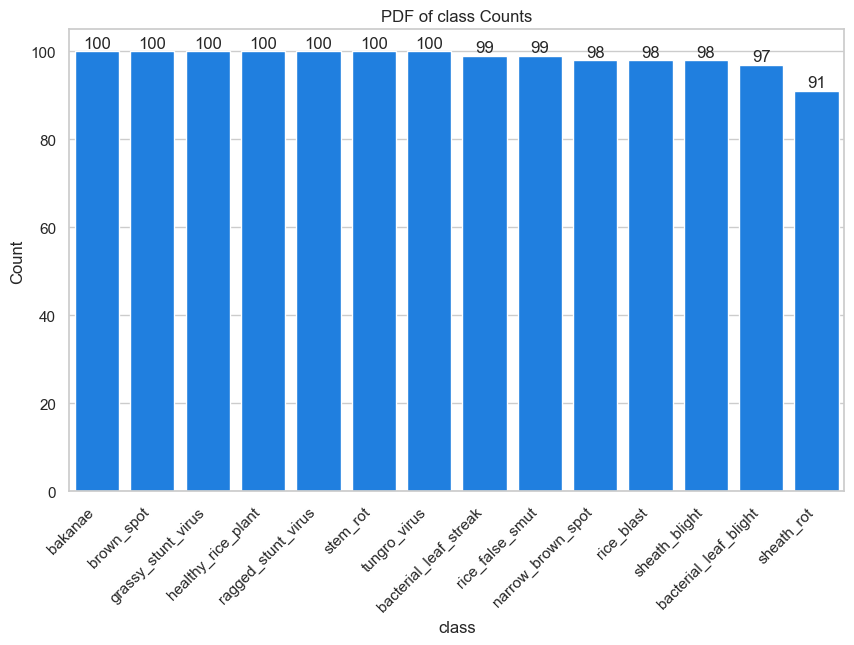

In [6]:
complete_count = count_and_plot_pdf(complete_df, 'class')

In [7]:
complete_count

,Class,Count
0,bakanae,100
1,brown_spot,100
2,grassy_stunt_virus,100
3,healthy_rice_plant,100
4,ragged_stunt_virus,100
5,stem_rot,100
6,tungro_virus,100
7,bacterial_leaf_streak,99
8,rice_false_smut,99
9,narrow_brown_spot,98


**Zoomed_images_df**

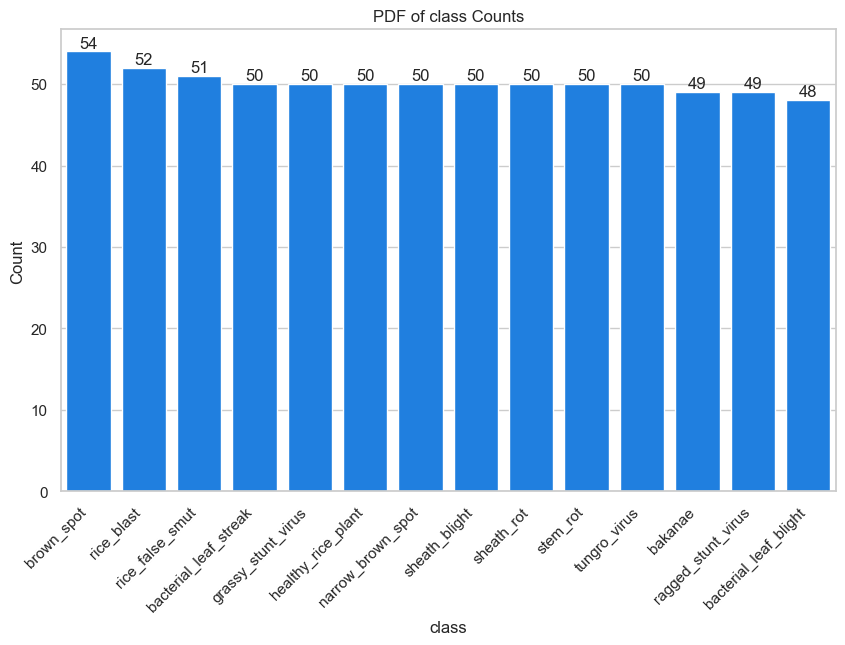

In [8]:
zoom_count = count_and_plot_pdf(zoom_df, 'class')

In [9]:
zoom_count

,Class,Count
0,brown_spot,54
1,rice_blast,52
2,rice_false_smut,51
3,bacterial_leaf_streak,50
4,grassy_stunt_virus,50
5,healthy_rice_plant,50
6,narrow_brown_spot,50
7,sheath_blight,50
8,sheath_rot,50
9,stem_rot,50


**Three_class_counts**

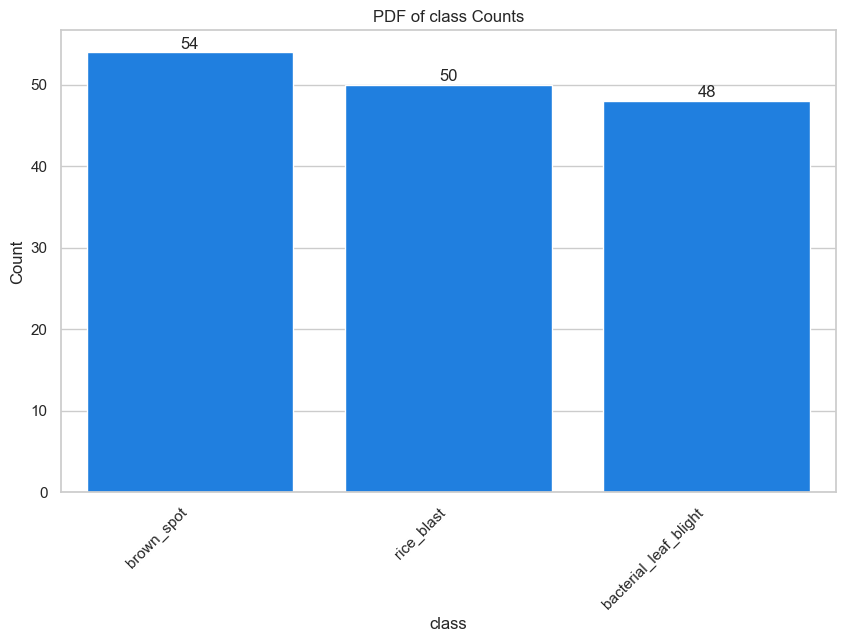

In [10]:
three_class_count = count_and_plot_pdf(three_df, 'class')

In [11]:
three_class_count

,Class,Count
0,brown_spot,54
1,rice_blast,50
2,bacterial_leaf_blight,48


# Feature Extraction

## Texture Features

In [12]:
def compute_glcm_features(df):
    df['gray'] = df['rgb'].apply(lambda x: cv2.cvtColor(np.uint8(x), cv2.COLOR_RGB2GRAY))
    def calculate_glcm(gray_image):
        # Compute GLCM using mahotas
        glcm = mahotas.features.haralick(gray_image.astype(np.uint8), ignore_zeros=True)
        return glcm.mean(axis=0)

    features = []

    start_time = time.time()
    
    for index, row in df.iterrows():
        gray_image = row['gray']
        glcm_features = calculate_glcm(gray_image)
        features.append(glcm_features)

    end_time = time.time()
    elapsed_time = end_time - start_time

    # Define meaningful column names for GLCM features
    glcm_columns = [
        'Angular Second Moment',
        'Contrast',
        'Correlation',
        'Sum of Squares: Variance',
        'Inverse Difference Moment',
        'Sum Average',
        'Sum Variance',
        'Sum Entropy',
        'Entropy',
        'Difference Variance',
        'Difference Entropy',
        'Informational Measure of Correlation 1',
        'Informational Measure of Correlation 2'
    ]

    # Create a DataFrame with the new GLCM features and meaningful column names
    glcm_df = pd.DataFrame(features, columns=[f'GLCM_{col}' for col in glcm_columns])

    # Concatenate the new DataFrame with the original DataFrame
    result_df = pd.concat([df, glcm_df], axis=1)

    print(f"Elapsed Time: {elapsed_time:.2f} seconds")

    return result_df

## Histogram Features

In [13]:
def values(dataframe):
    # Ensure the 'rgb' column exists in the dataframe
    dataframe['hsv'] = dataframe['rgb'].apply(lambda x: cv2.cvtColor(np.uint8(x), cv2.COLOR_RGB2HSV))
    #dataframe['hsi'] = dataframe['rgb'].apply(lambda x: color.rgb2hsi(np.uint8(x)))
    dataframe['lab'] = dataframe['rgb'].apply(lambda x: cv2.cvtColor(np.uint8(x), cv2.COLOR_RGB2LAB))

    dataframe['red'] = dataframe['rgb'].apply(lambda rgb: rgb[:,:,0])
    dataframe['green'] = dataframe['rgb'].apply(lambda rgb: rgb[:,:,1])
    dataframe['blue'] = dataframe['rgb'].apply(lambda rgb: rgb[:,:,2])
    
    dataframe['hue_v'] = dataframe['hsv'].apply(lambda hsv: hsv[:,:,0])
    dataframe['saturation_v'] = dataframe['hsv'].apply(lambda hsv: hsv[:,:,1])
    dataframe['value_v'] = dataframe['hsv'].apply(lambda hsv: hsv[:,:,2])
    
    #dataframe['hue_i'] = dataframe['hsv'].apply(lambda hsi: hsi[:,:,0])
    #dataframe['saturation_i'] = dataframe['hsv'].apply(lambda hsi: hsi[:,:,1])
    #dataframe['intensity_i'] = dataframe['hsv'].apply(lambda hsi: hsi[:,:,2])
    
    dataframe['lightness'] = dataframe['lab'].apply(lambda lab: lab[:, :, 0])
    dataframe['a'] = dataframe['lab'].apply(lambda lab: lab[:, :, 1])
    dataframe['b'] = dataframe['lab'].apply(lambda lab: lab[:, :, 2])

    return dataframe

In [14]:
def create_bins_dataframe(dataframe, col, num_bins):
    bins_dataframe = pd.DataFrame()

    #print(col)
    min_value = np.min([np.min(matrix) for matrix in dataframe[col]])
    max_value = np.max([np.max(matrix) for matrix in dataframe[col]])

    bin_edges = np.linspace(min_value, max_value, num_bins + 1)
    bin_column_names = [f'{col}_{i}' for i in range(1, num_bins + 1)]
    
    for matrix in dataframe[col]:
        bin_indices = np.digitize(matrix.flatten(), bin_edges, right=True)
        bin_counts = np.bincount(bin_indices, minlength=num_bins + 1)[1:]

        bins_dataframe = pd.concat([bins_dataframe, pd.DataFrame(bin_counts).transpose()], axis=0, ignore_index=True)

    bins_dataframe.columns = bin_column_names
        
    return bins_dataframe

def hist_features(df, cols, bins):
    complete_bins = pd.DataFrame()

    for col in cols:
        col_bins = create_bins_dataframe(df, col, bins)
        complete_bins = pd.concat([complete_bins, col_bins], axis=1)

    return complete_bins

cols = ['red', 'green', 'blue', 'hue_v', 'saturation_v', 'value_v', 'lightness', 'a', 'b']

## Color Moments Features

In [15]:
def split_channels(dataframe):
    # Extracting channel values from 'hsv', 'lab', and 'rgb' columns
    dataframe['h_channel'] = dataframe['hsv'].apply(lambda x: x[0])
    dataframe['s_channel'] = dataframe['hsv'].apply(lambda x: x[1])
    dataframe['v_channel'] = dataframe['hsv'].apply(lambda x: x[2])

    dataframe['l_channel'] = dataframe['lab'].apply(lambda x: x[0])
    dataframe['a_channel'] = dataframe['lab'].apply(lambda x: x[1])
    dataframe['b_channel'] = dataframe['lab'].apply(lambda x: x[2])

    dataframe['red_channel'] = dataframe['rgb'].apply(lambda x: x[0])
    dataframe['green_channel'] = dataframe['rgb'].apply(lambda x: x[1])
    dataframe['blue_channel'] = dataframe['rgb'].apply(lambda x: x[2])

    # Flatten each channel
    for column in ['h_channel', 's_channel', 'v_channel',
                   'l_channel', 'a_channel', 'b_channel',
                   'red_channel', 'green_channel', 'blue_channel']:
        dataframe[column] = dataframe[column].apply(lambda x: x.flatten())

    # Creating a new DataFrame with the flattened channels
    flattened_dataframe = dataframe[['h_channel', 's_channel', 'v_channel',
                                     'l_channel', 'a_channel', 'b_channel',
                                     'red_channel', 'green_channel', 'blue_channel']]

    return flattened_dataframe

In [16]:
def calculate_vector_statistics(df, column_name):
    result_df = pd.DataFrame()  # Create an empty DataFrame to store the results
    vectors = df[column_name]

    # Calculate statistics for each vector
    average = vectors.apply(lambda x: np.mean(x))
    kurt = vectors.apply(lambda x: kurtosis(x))
    skewness = vectors.apply(lambda x: skew(x))
    variance = vectors.apply(lambda x: np.var(x))

    # Create a new DataFrame with the calculated statistics
    column_stats = pd.DataFrame({
        f'{column_name}_average': average,
        f'{column_name}_kurtosis': kurt,
        f'{column_name}_skewness': skewness,
        f'{column_name}_variance': variance
    })

    return column_stats

In [17]:
import numpy as np
import pandas as pd
from scipy.stats import kurtosis, skew

def calculate_vector_statistics(df, column_name, variance_threshold=1e-10):
    result_df = pd.DataFrame()  # Create an empty DataFrame to store the results
    vectors = df[column_name]

    # Calculate statistics for each vector
    average = vectors.apply(lambda x: np.mean(x))
    variance = vectors.apply(lambda x: np.var(x))

    # Check for small variance and set it to a small non-zero value
    small_variance_mask = variance < variance_threshold
    variance[small_variance_mask] = variance_threshold

    # Calculate kurtosis and skewness using the 'omit' nan_policy
    kurt = vectors.apply(lambda x: kurtosis(x, nan_policy='omit'))
    skewness = vectors.apply(lambda x: skew(x, nan_policy='omit'))

    # Create a new DataFrame with the calculated statistics
    column_stats = pd.DataFrame({
        f'{column_name}_average': average,
        f'{column_name}_kurtosis': kurt,
        f'{column_name}_skewness': skewness,
        f'{column_name}_variance': variance
    })

    return column_stats

In [18]:
def color_moments(df):
    cols = df.columns.to_list()
    
    final_df = pd.DataFrame(columns=['cols'])
    for i in range(len(cols)):
        new_df = calculate_vector_statistics(df, cols[i])
        final_df = pd.concat([final_df,new_df], axis=1)
        
    final_df = final_df.iloc[:,1:]
    return final_df

## Zernike Features

In [19]:
def zernike(df, zernike_order):
    features_list = []

    for idx, row in df.iterrows():
        gray_img = row['gray']

        # Check if the image is grayscale
        if len(gray_img.shape) == 2:
            # If grayscale, compute Zernike moments directly
            moments = mahotas.features.zernike_moments(gray_img, radius=zernike_order)
            moments = moments.astype(float)
        else:
            raise ValueError("Input image must be grayscale.")

        features_list.append(moments)

    # Determine the number of features per image
    num_features_per_image = len(features_list[0])

    # Add features to the DataFrame
    feature_columns = [f'feature_{i}' for i in range(num_features_per_image)]
    df_features = pd.DataFrame(features_list, columns=feature_columns)
    df_result = pd.concat([df, df_features], axis=1)
    
    return df_result

In [20]:
def zernike(dataframe, degree):
    # Initialize an empty DataFrame to store Zernike features
    zernike_dataframe = pd.DataFrame()

    # Iterate over each row in the input DataFrame
    for index, row in dataframe.iterrows():
        # Extract grayscale values from the "gray" column
        grayscale_values = row['gray']

        # Compute Zernike moments
        zernike_moments = mahotas.features.zernike_moments(grayscale_values, degree)

        # Create a DataFrame with the computed Zernike moments
        zernike_row = pd.DataFrame(zernike_moments).transpose()

        # Concatenate the Zernike features to the output DataFrame
        zernike_dataframe = pd.concat([zernike_dataframe, zernike_row], ignore_index=True)

    return zernike_dataframe

## Legendre Moments

In [21]:
def compute_legendre_features(rgb_image, degree):
    # Get V channel from RGB image
    v_channel = rgb_image[:, :, 2]

    # Define x and y coordinates
    x_size, y_size = v_channel.shape
    x = np.linspace(-1, 1, x_size)
    y = np.linspace(-1, 1, y_size)

    # Compute Legendre features for the V channel
    legendre_features = np.zeros((degree + 1, degree + 1))

    for j in range(degree + 1):
        for k in range(degree + 1):
            legendre_features[j, k] = np.sum(v_channel * legendre(j)(x) * legendre(k)(y))

    return legendre_features.flatten()

def add_legendre(df, degree):
    # Create a new DataFrame for Legendre features
    legendre_columns = [f'v_legendre_{i}_{j}' for i in range(degree + 1) for j in range(degree + 1)]
    legendre_df = pd.DataFrame(df['rgb'].apply(lambda rgb: compute_legendre_features(rgb, degree)).values.tolist(), columns=legendre_columns)

    # Concatenate the new DataFrame with the original DataFrame
    result_df = pd.concat([df, legendre_df], axis=1)

    return result_df

# Data Normalization and One Hot Encoding

In [22]:
def normalize_dataframe(df):
    # Create a MinMaxScaler instance
    scaler = MinMaxScaler()

    # Extract numerical columns (assuming only numerical columns need normalization)
    numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

    # Apply normalization to each numerical column
    df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

    return df

# Complete Feature Extraction

In [32]:
def complete_feature_extraction(df, hist_bins, zernike_param, legendre_param, features):
    
    complete_features = pd.DataFrame(df['class'])
    
    if 'f_glcm' in features:
        #TEXTURE FEATURES
        print("Generating Texture Features")
        start_time = time.time()
        start_time_str = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        print(f"Start time: {start_time_str}")

        glcm = compute_glcm_features(df)
        f_glcm = glcm.iloc[:, 4:]
        print(np.shape(f_glcm))
        complete_features=pd.concat([complete_features, f_glcm], axis=1)

        elapsed_time = time.time() - start_time
        elapsed_minutes, elapsed_seconds = divmod(int(elapsed_time), 60)
        print(f"Time elapsed: {elapsed_minutes} minutes and {elapsed_seconds} seconds")
        print("----------------------")

    if 'f_histogram' in features:
        #COLOR HISTOGRAM FEATURES
        print("Generating Color Histogram Features")
        start_time = time.time()
        start_time_str = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        print(f"Start time: {start_time_str}")

        channels = values(df)
        f_histogram = hist_features(channels, ['red', 'green', 'blue', 'hue_v', 'saturation_v', 'value_v', 'lightness', 'a', 'b'], hist_bins)
        print(np.shape(f_histogram))
        complete_features=pd.concat([complete_features, f_histogram], axis=1)

        elapsed_time = time.time() - start_time
        elapsed_minutes, elapsed_seconds = divmod(int(elapsed_time), 60)
        print(f"Time elapsed: {elapsed_minutes} minutes and {elapsed_seconds} seconds")
        print("----------------------")
    
    if 'f_color' in features:
        #COLOR MOMENT FEATURES
        print("Generating Color Moments Features")
        start_time = time.time()
        start_time_str = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        print(f"Start time: {start_time_str}")

        channels = split_channels(df)
        f_color = color_moments(channels)
        f_color = f_color.fillna(0)
        print(np.shape(f_color))
        complete_features=pd.concat([complete_features, f_color], axis=1)

        elapsed_time = time.time() - start_time
        elapsed_minutes, elapsed_seconds = divmod(int(elapsed_time), 60)
        print(f"Time elapsed: {elapsed_minutes} minutes and {elapsed_seconds} seconds")    
        print("----------------------")
    
    if 'f_zernike' in features:
        #ZERNIKE FEATURES
        print("Generating Zernike Features")
        start_time = time.time()
        start_time_str = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        print(f"Start time: {start_time_str}")

        f_zernike = zernike(df, zernike_param)
        print(np.shape(f_zernike))
        complete_features=pd.concat([complete_features, f_zernike], axis=1)

        elapsed_time = time.time() - start_time
        elapsed_minutes, elapsed_seconds = divmod(int(elapsed_time), 60)
        print(f"Time elapsed: {elapsed_minutes} minutes and {elapsed_seconds} seconds")
        print("----------------------")

    if 'f_legendre' in features:
        #LEGENDRE MOMENTS FEATURES
        print("Generating Legendre Moments Features")
        start_time = time.time()
        start_time_str = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        print(f"Start time: {start_time_str}")

        l_input = df.drop(columns=['class','hsv','lab','red','green','blue', 'hue_v', 'saturation_v', 'value_v', 'lightness', 'a', 'b'])
        l_input = l_input.iloc[:, :4]
        legendre_df = add_legendre(l_input, legendre_param)
        f_legendre = legendre_df.iloc[:, 4:]
        print(np.shape(f_legendre))
        complete_features=pd.concat([complete_features, f_legendre], axis=1)

        elapsed_time = time.time() - start_time
        elapsed_minutes, elapsed_seconds = divmod(int(elapsed_time), 60)
        print(f"Time elapsed: {elapsed_minutes} minutes and {elapsed_seconds} seconds")
        print("----------------------")
    
    
    #COMPILIE FEATURES
    
    columns_to_drop = ['hsv', 'lab', 'red', 'green', 'blue', 'hue_v', 'saturation_v', 'value_v', 'lightness', 'a', 'b', 'h_channel', 's_channel', 'v_channel', 'l_channel', 'a_channel', 'b_channel', 'red_channel', 'green_channel', 'blue_channel']

    # Drop columns only if they exist in the DataFrame
    for column in columns_to_drop:
        if column in complete_features.columns:
            complete_features.drop(columns=column, inplace=True)
    
    print("normalizing")
    complete_features.columns = complete_features.columns.astype(str)
    
    norm_df = normalize_dataframe(complete_features)
    
    label_encoder = LabelEncoder()
    norm_df['class'] = label_encoder.fit_transform(norm_df['class'])

    return norm_df

# SVM

**Train Test Split**

In [24]:
def df_train_test_split(df, target_column, test_size=0.2, random_state=None):
    # Features
    X = df.drop(columns=[target_column])

    # Target variable
    y = df[target_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    x = df.iloc[:,1:]
    y = df.iloc[:,0] 

    return X_train, X_test, y_train, y_test, x, y

**SVM Classifier**

In [25]:
def train_svm_classifier(X_train, y_train, X_test, y_test, kernel, C, k_folds):
    # Create an SVM classifier
    svm_classifier = SVC(kernel=kernel, C=C)

    # Define the hyperparameters grid
    param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [0.01, 0.1, 1, 10]}

    # Create the GridSearchCV object with k-fold cross-validation
    grid_search = GridSearchCV(svm_classifier, param_grid, cv=StratifiedKFold(n_splits=k_folds))

    # Fit the model to the training data
    grid_search.fit(X_train, y_train)

    # Get the best parameters and the best estimator
    best_params = grid_search.best_params_
    best_estimator = grid_search.best_estimator_

    # Make predictions on the test set
    y_pred = best_estimator.predict(X_test)

    # Evaluate the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Best parameters: {best_params}")
    print(f"Accuracy: {accuracy * 100:.2f}%")

    return best_estimator, accuracy

In [26]:
def train_svm_classifier(X_train, y_train, X_test, y_test, kernel='linear', C=1.0):
    # Create an SVM classifier
    svm_classifier = SVC(kernel=kernel, C=C)

    # Train the classifier
    svm_classifier.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = svm_classifier.predict(X_test)

    # Evaluate the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    return svm_classifier, accuracy

# Feature Selection PCA

In [27]:
def apply_pca_for_feature_selection(X, desired_variance_ratio):
    pca = PCA(n_components=desired_variance_ratio)
    reduced_features = pca.fit_transform(X)
    return reduced_features, pca

def pca(X, y, test_size=0.2, random_state=42):

    variance_ratios = [i / 1000 for i in range(970, 1000)]
    accuracy_per_variance = []

    max_accuracy = 0.0
    best_selected_features = None
    best_pca_model = None

    for desired_variance_ratio in variance_ratios:
        reduced_features, pca_model = apply_pca_for_feature_selection(X, desired_variance_ratio)
        print(f"var: {desired_variance_ratio}")
        print(np.shape(reduced_features))

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(reduced_features, y, test_size=test_size, random_state=random_state)

        # Create an SVM classifier
        svm_classifier = SVC(kernel='linear')

        # Train the SVM classifier using the selected features
        svm_classifier.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = svm_classifier.predict(X_test)

        # Evaluate the performance of the SVM classifier
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {accuracy}")

        # Update max accuracy and store corresponding features
        if accuracy > max_accuracy:
            max_accuracy = accuracy
            best_selected_features = reduced_features.copy()
            best_pca_model = pca_model

        accuracy_per_variance.append((desired_variance_ratio, accuracy))

    # Create a table showing accuracy per variance
    accuracy_table = pd.DataFrame(accuracy_per_variance, columns=['Variance Ratio', 'Accuracy'])

    # Plotting the line plot
    plt.plot(accuracy_table['Variance Ratio'], accuracy_table['Accuracy'], marker='o')
    plt.title('Accuracy vs Variance Ratio')
    plt.xlabel('Variance Ratio')
    plt.ylabel('Accuracy')
    plt.show()

    return best_selected_features, max_accuracy, accuracy_table

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

def apply_pca_for_feature_selection(X, desired_variance_ratio):
    pca = PCA(n_components=desired_variance_ratio)
    reduced_features = pca.fit_transform(X)
    return reduced_features, pca

def pca(X, y, test_size=0.2, random_state=42):

    variance_ratios = [i / 1000 for i in range(970, 1000)]
    accuracy_per_variance = []

    max_accuracy = 0.0
    best_selected_features = None
    best_pca_model = None

    for desired_variance_ratio in variance_ratios:
        reduced_features, pca_model = apply_pca_for_feature_selection(X, desired_variance_ratio)
        print(f"var: {desired_variance_ratio}")
        print(np.shape(reduced_features))

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(reduced_features, y, test_size=test_size, random_state=random_state)

        # Create an SVM classifier
        svm_classifier = SVC(kernel='linear')

        # Train the SVM classifier using the selected features
        svm_classifier.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = svm_classifier.predict(X_test)

        # Evaluate the performance of the SVM classifier
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {accuracy}")

        # Update max accuracy and store corresponding features
        if accuracy > max_accuracy:
            max_accuracy = accuracy
            best_selected_features = reduced_features.copy()
            best_pca_model = pca_model

        accuracy_per_variance.append((desired_variance_ratio, accuracy))

    # Create a table showing accuracy per variance
    accuracy_table = pd.DataFrame(accuracy_per_variance, columns=['Variance Ratio', 'Accuracy'])

    # Plotting the line plot
    plt.plot(accuracy_table['Variance Ratio'], accuracy_table['Accuracy'], marker='o')
    plt.title('Accuracy vs Variance Ratio')
    plt.xlabel('Variance Ratio')
    plt.ylabel('Accuracy')
    plt.show()

    # Get the top 10 selected features and their values
    top_10_features = best_selected_features[:, :10]

    return best_selected_features, max_accuracy, accuracy_table, top_10_features

## SVM Hyperparameter Tuning

In [28]:
def perform_grid_search(X, y, param_grid, test_size=0.2, random_state=42):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Define the SVM classifier
    svm_classifier = SVC()

    # Create a GridSearchCV object
    grid_search = GridSearchCV(svm_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1, return_train_score=True)

    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)

    # Get the best hyperparameters
    best_params = grid_search.best_params_

    # Get the best model
    best_svm_model = grid_search.best_estimator_

    # Evaluate the best model on the test set
    y_pred = best_svm_model.predict(X_test)

    # Calculate evaluation metrics
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    accuracy = report_dict['accuracy']
    weighted_recall = report_dict['weighted avg']['recall']
    weighted_precision = report_dict['weighted avg']['precision']
    weighted_f1_score = report_dict['weighted avg']['f1-score']
    support = report_dict['weighted avg']['support']

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Store results in a DataFrame
    results_df = pd.DataFrame({
        'Parameters': [best_params],
        'Accuracy': [accuracy],
        'Weighted Recall': [weighted_recall],
        'Weighted Precision': [weighted_precision],
        'Weighted F1 Score': [weighted_f1_score],
        'Support': [support],
        'Confusion Matrix': [cm]
    })

    # Add rows for each combination of hyperparameters
    for i, params in enumerate(grid_search.cv_results_['params']):
        results_df = pd.concat([results_df, pd.DataFrame({
            'Parameters': [params],
            'Accuracy': [grid_search.cv_results_['mean_test_score'][i]],
            'Weighted Recall': [grid_search.cv_results_['mean_test_score'][i]],
            'Weighted Precision': [grid_search.cv_results_['mean_test_score'][i]],
            'Weighted F1 Score': [grid_search.cv_results_['mean_test_score'][i]],
            'Support': [grid_search.cv_results_['mean_test_score'][i]],
            'Confusion Matrix': [confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test))]
        })])

    # Reset index
    results_df.reset_index(drop=True, inplace=True)

    return results_df, best_params, best_svm_model

In [29]:
def plot_confusion_matrix(df, row_index):
    conf_matrix =  df.at[row_index,'Confusion Matrix']
    r, c = np.shape(conf_matrix)
    classes = list(range(c))
    # Create a DataFrame for the confusion matrix
    conf_df = pd.DataFrame(conf_matrix, index=classes, columns=classes)

    # Plot the heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_df, annot=True, fmt="d", cmap="Blues", linewidths=.5, cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# SVM Hyperparameter 

In [50]:
def svm(df, t_size, k, c, g):
    #Train Test Split
    x_tr, x_te, y_tr, y_te, x_d, y_d = df_train_test_split(df, target_column='class', test_size = t_size, random_state=None)
    
    classifier, acc = train_svm_classifier(x_tr, y_tr, x_te, y_te, 'linear', 1.0)
    print(f"Initial Model Accuracy: {acc}")
    print("-------------------")
    print("-------------------")
    
    #Feature Selection PCA
    selected_features, max_accuracy, accuracy_table, top_10 = pca(x_d, y_d)
    print(f"Max Accuracy{max_accuracy}")
    print(f"Number of Features: {selected_features.shape[1]}")
    print(f"Top 10 Features{top_10}")
    print("-------------------")
    print("-------------------")
    
    # Define the hyperparameter grid
    param_grid = {
        'C': c,
        'kernel': k,
        'gamma': g
    }

    # Perform grid search
    results_table, best_params, best_model = perform_grid_search(selected_features, y_d, param_grid)
    
    return results_table, best_params, best_model

In [33]:
three_input = complete_feature_extraction(three_df, 82, 10, 10, ['f_glcm', 'f_histogram', 'f_color', 'f_zernike', 'f_legendre'])

Generating Texture Features
Start time: 2024-01-17 12:16:52
Elapsed Time: 1.59 seconds
(152, 33)
Time elapsed: 0 minutes and 1 seconds
----------------------
Generating Color Histogram Features
Start time: 2024-01-17 12:16:53
(152, 738)
Time elapsed: 0 minutes and 2 seconds
----------------------
Generating Color Moments Features
Start time: 2024-01-17 12:16:55
(152, 36)
Time elapsed: 0 minutes and 1 seconds
----------------------
Generating Zernike Features
Start time: 2024-01-17 12:16:57
(152, 25)
Time elapsed: 0 minutes and 0 seconds
----------------------
Generating Legendre Moments Features
Start time: 2024-01-17 12:16:57
(152, 121)
Time elapsed: 0 minutes and 7 seconds
----------------------
normalizing


Accuracy: 80.65%
Initial Model Accuracy: 0.8064516129032258
-------------------
-------------------
var: 0.97
(152, 78)
Accuracy: 0.9354838709677419
var: 0.971
(152, 79)
Accuracy: 0.9354838709677419
var: 0.972
(152, 80)
Accuracy: 0.9354838709677419
var: 0.973
(152, 81)
Accuracy: 0.9354838709677419
var: 0.974
(152, 82)
Accuracy: 0.9354838709677419
var: 0.975
(152, 83)
Accuracy: 0.9354838709677419
var: 0.976
(152, 84)
Accuracy: 0.9354838709677419
var: 0.977
(152, 85)
Accuracy: 0.9354838709677419
var: 0.978
(152, 86)
Accuracy: 0.9354838709677419
var: 0.979
(152, 87)
Accuracy: 0.9354838709677419
var: 0.98
(152, 88)
Accuracy: 0.9354838709677419
var: 0.981
(152, 90)
Accuracy: 0.9354838709677419
var: 0.982
(152, 91)
Accuracy: 0.9354838709677419
var: 0.983
(152, 92)
Accuracy: 0.9354838709677419
var: 0.984
(152, 94)
Accuracy: 0.9354838709677419
var: 0.985
(152, 95)
Accuracy: 0.9354838709677419
var: 0.986
(152, 97)
Accuracy: 0.9354838709677419
var: 0.987
(152, 98)
Accuracy: 0.9354838709677419
va

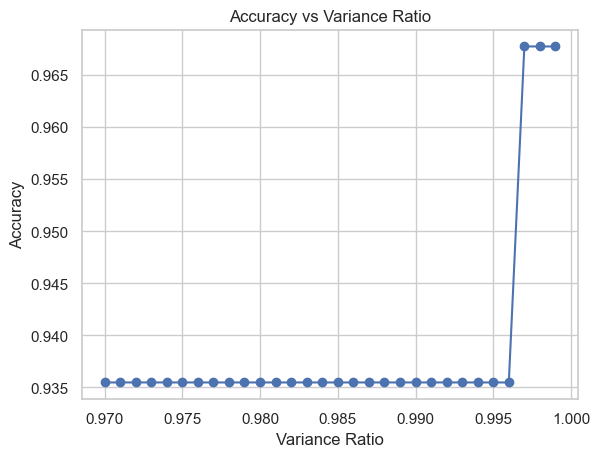

Max Accuracy0.967741935483871
Number of Features: 124
Top 10 Features[[ 3.40720493  0.54236749  0.27296755 ... -1.66991079 -0.80241123
   1.07698843]
 [-2.21507812  3.63973276 -0.15968618 ... -0.88825413  0.18225975
   0.05122204]
 [-2.33824956  3.28575546  0.5376049  ... -0.32612606 -0.22347542
  -0.03018171]
 ...
 [ 3.17170868 -0.12317742  0.37984549 ...  0.07506295  0.21948013
  -0.97747087]
 [ 1.0314679  -0.31774368 -1.89259233 ... -0.99540836  0.18770451
  -0.53488158]
 [ 4.03107485  0.48678631 -1.60996826 ...  3.7229294   1.68603998
   2.65385617]]
-------------------
-------------------


In [53]:
t_results, t_params, t_model = svm(three_input, .2, ['rbf','linear','poly'], [1, 10, 100], [.001, .01, .1])

In [35]:
t_results.sort_values(by='Accuracy', ascending = False)

,Parameters,Accuracy,Weighted Recall,Weighted Precision,Weighted F1 Score,Support,Confusion Matrix
0,"{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}",0.967742,0.967742,0.970674,0.967742,31.000000,"[[10, 0, 0], [0, 10, 0], [0, 1, 10]]"
13,"{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}",0.892667,0.892667,0.892667,0.892667,0.892667,"[[10, 0, 0], [0, 10, 0], [0, 1, 10]]"
22,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.884667,0.884667,0.884667,0.884667,0.884667,"[[10, 0, 0], [0, 10, 0], [0, 1, 10]]"
19,"{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}",0.884333,0.884333,0.884333,0.884333,0.884333,"[[10, 0, 0], [0, 10, 0], [0, 1, 10]]"
11,"{'C': 10, 'gamma': 0.001, 'kernel': 'linear'}",0.867667,0.867667,0.867667,0.867667,0.867667,"[[10, 0, 0], [0, 10, 0], [0, 1, 10]]"
26,"{'C': 100, 'gamma': 0.1, 'kernel': 'linear'}",0.867667,0.867667,0.867667,0.867667,0.867667,"[[10, 0, 0], [0, 10, 0], [0, 1, 10]]"
23,"{'C': 100, 'gamma': 0.01, 'kernel': 'linear'}",0.867667,0.867667,0.867667,0.867667,0.867667,"[[10, 0, 0], [0, 10, 0], [0, 1, 10]]"
20,"{'C': 100, 'gamma': 0.001, 'kernel': 'linear'}",0.867667,0.867667,0.867667,0.867667,0.867667,"[[10, 0, 0], [0, 10, 0], [0, 1, 10]]"
17,"{'C': 10, 'gamma': 0.1, 'kernel': 'linear'}",0.867667,0.867667,0.867667,0.867667,0.867667,"[[10, 0, 0], [0, 10, 0], [0, 1, 10]]"
14,"{'C': 10, 'gamma': 0.01, 'kernel': 'linear'}",0.867667,0.867667,0.867667,0.867667,0.867667,"[[10, 0, 0], [0, 10, 0], [0, 1, 10]]"


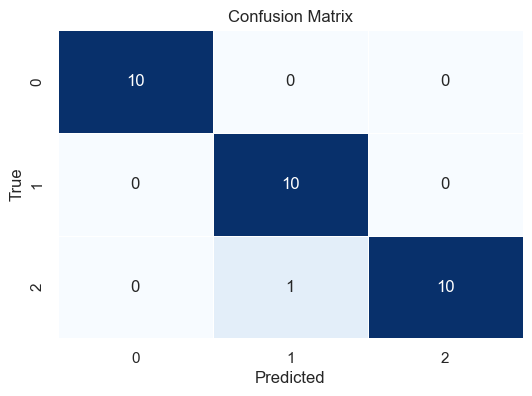

In [36]:
plot_confusion_matrix(t_results, 0)

In [37]:
zoom_input = complete_feature_extraction(zoom_df, 82, 10, 10, ['f_glcm', 'f_histogram', 'f_color', 'f_zernike', 'f_legendre'])

Generating Texture Features
Start time: 2024-01-17 12:17:28
Elapsed Time: 8.39 seconds
(703, 13)
Time elapsed: 0 minutes and 8 seconds
----------------------
Generating Color Histogram Features
Start time: 2024-01-17 12:17:36
(703, 738)
Time elapsed: 0 minutes and 10 seconds
----------------------
Generating Color Moments Features
Start time: 2024-01-17 12:17:46


C:\Users\isabe\AppData\Local\Temp\ipykernel_18280\4170511435.py:18: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt = vectors.apply(lambda x: kurtosis(x, nan_policy='omit'))
C:\Users\isabe\AppData\Local\Temp\ipykernel_18280\4170511435.py:19: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewness = vectors.apply(lambda x: skew(x, nan_policy='omit'))
C:\Users\isabe\AppData\Local\Temp\ipykernel_18280\4170511435.py:18: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt = vectors.apply(lambda x: kurtosis(x, nan_policy='omit'))
C:\Users\isabe\AppData\Local\Temp\ipykernel_18280\4170511435.py:19: RuntimeWarning: Prec

(703, 36)
Time elapsed: 0 minutes and 5 seconds
----------------------
Generating Zernike Features
Start time: 2024-01-17 12:17:52
(703, 25)
Time elapsed: 0 minutes and 1 seconds
----------------------
Generating Legendre Moments Features
Start time: 2024-01-17 12:17:53
(703, 121)
Time elapsed: 0 minutes and 35 seconds
----------------------
normalizing


Accuracy: 88.65%
Initial Model Accuracy: 0.8865248226950354
-------------------
-------------------
var: 0.97
(703, 133)
Accuracy: 0.9361702127659575
var: 0.971
(703, 135)
Accuracy: 0.9361702127659575
var: 0.972
(703, 137)
Accuracy: 0.9361702127659575
var: 0.973
(703, 139)
Accuracy: 0.9361702127659575
var: 0.974
(703, 142)
Accuracy: 0.9361702127659575
var: 0.975
(703, 145)
Accuracy: 0.9290780141843972
var: 0.976
(703, 147)
Accuracy: 0.9361702127659575
var: 0.977
(703, 150)
Accuracy: 0.9361702127659575
var: 0.978
(703, 153)
Accuracy: 0.9361702127659575
var: 0.979
(703, 156)
Accuracy: 0.9290780141843972
var: 0.98
(703, 159)
Accuracy: 0.9290780141843972
var: 0.981
(703, 163)
Accuracy: 0.9290780141843972
var: 0.982
(703, 167)
Accuracy: 0.9290780141843972
var: 0.983
(703, 171)
Accuracy: 0.9290780141843972
var: 0.984
(703, 175)
Accuracy: 0.9290780141843972
var: 0.985
(703, 179)
Accuracy: 0.9290780141843972
var: 0.986
(703, 184)
Accuracy: 0.9290780141843972
var: 0.987
(703, 189)
Accuracy: 0.9

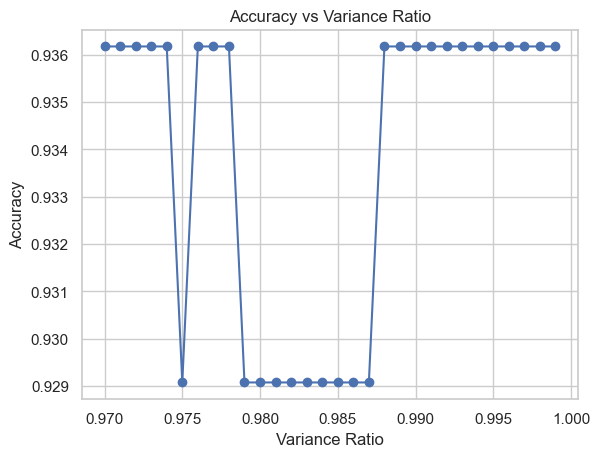

Max Accuracy0.9361702127659575
Number of Features: 133
-------------------
-------------------


In [38]:
z_results, z_params, z_model = svm(zoom_input, .2, ['rbf','linear','poly'], [1, 10, 100], [.001, .01, .1])

In [39]:
z_results.sort_values(by='Accuracy', ascending = False)

,Parameters,Accuracy,Weighted Recall,Weighted Precision,Weighted F1 Score,Support,Confusion Matrix
0,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.936170,0.936170,0.940426,0.936095,141.000000,"[[9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [..."
22,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.875506,0.875506,0.875506,0.875506,0.875506,"[[9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [..."
25,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.873736,0.873736,0.873736,0.873736,0.873736,"[[9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [..."
16,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.873736,0.873736,0.873736,0.873736,0.873736,"[[9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [..."
11,"{'C': 10, 'gamma': 0.001, 'kernel': 'linear'}",0.871950,0.871950,0.871950,0.871950,0.871950,"[[9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [..."
26,"{'C': 100, 'gamma': 0.1, 'kernel': 'linear'}",0.871950,0.871950,0.871950,0.871950,0.871950,"[[9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [..."
23,"{'C': 100, 'gamma': 0.01, 'kernel': 'linear'}",0.871950,0.871950,0.871950,0.871950,0.871950,"[[9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [..."
20,"{'C': 100, 'gamma': 0.001, 'kernel': 'linear'}",0.871950,0.871950,0.871950,0.871950,0.871950,"[[9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [..."
17,"{'C': 10, 'gamma': 0.1, 'kernel': 'linear'}",0.871950,0.871950,0.871950,0.871950,0.871950,"[[9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [..."
14,"{'C': 10, 'gamma': 0.01, 'kernel': 'linear'}",0.871950,0.871950,0.871950,0.871950,0.871950,"[[9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [..."


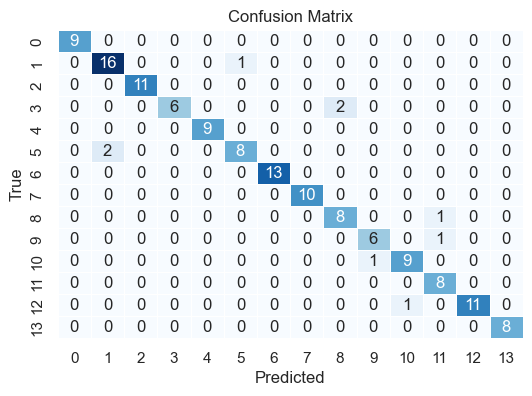

In [40]:
plot_confusion_matrix(z_results, 0)

In [41]:
complete_input = complete_feature_extraction(complete_df, 82, 10, 10, ['f_glcm', 'f_histogram', 'f_color', 'f_zernike', 'f_legendre'])

Generating Texture Features
Start time: 2024-01-17 12:18:35
Elapsed Time: 16.14 seconds
(1380, 13)
Time elapsed: 0 minutes and 16 seconds
----------------------
Generating Color Histogram Features
Start time: 2024-01-17 12:18:51
(1380, 738)
Time elapsed: 0 minutes and 20 seconds
----------------------
Generating Color Moments Features
Start time: 2024-01-17 12:19:12


C:\Users\isabe\AppData\Local\Temp\ipykernel_18280\4170511435.py:18: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt = vectors.apply(lambda x: kurtosis(x, nan_policy='omit'))
C:\Users\isabe\AppData\Local\Temp\ipykernel_18280\4170511435.py:19: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewness = vectors.apply(lambda x: skew(x, nan_policy='omit'))
C:\Users\isabe\AppData\Local\Temp\ipykernel_18280\4170511435.py:18: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt = vectors.apply(lambda x: kurtosis(x, nan_policy='omit'))
C:\Users\isabe\AppData\Local\Temp\ipykernel_18280\4170511435.py:19: RuntimeWarning: Prec

(1380, 36)
Time elapsed: 0 minutes and 10 seconds
----------------------
Generating Zernike Features
Start time: 2024-01-17 12:19:22
(1380, 25)
Time elapsed: 0 minutes and 2 seconds
----------------------
Generating Legendre Moments Features
Start time: 2024-01-17 12:19:25
(1380, 121)
Time elapsed: 1 minutes and 9 seconds
----------------------
normalizing


Accuracy: 80.80%
Initial Model Accuracy: 0.8079710144927537
-------------------
-------------------
var: 0.97
(1380, 133)
Accuracy: 0.8188405797101449
var: 0.971
(1380, 135)
Accuracy: 0.8188405797101449
var: 0.972
(1380, 138)
Accuracy: 0.822463768115942
var: 0.973
(1380, 140)
Accuracy: 0.822463768115942
var: 0.974
(1380, 143)
Accuracy: 0.8188405797101449
var: 0.975
(1380, 146)
Accuracy: 0.822463768115942
var: 0.976
(1380, 149)
Accuracy: 0.8297101449275363
var: 0.977
(1380, 152)
Accuracy: 0.8188405797101449
var: 0.978
(1380, 155)
Accuracy: 0.8188405797101449
var: 0.979
(1380, 159)
Accuracy: 0.8188405797101449
var: 0.98
(1380, 162)
Accuracy: 0.8188405797101449
var: 0.981
(1380, 166)
Accuracy: 0.822463768115942
var: 0.982
(1380, 170)
Accuracy: 0.822463768115942
var: 0.983
(1380, 174)
Accuracy: 0.822463768115942
var: 0.984
(1380, 179)
Accuracy: 0.8188405797101449
var: 0.985
(1380, 184)
Accuracy: 0.8188405797101449
var: 0.986
(1380, 189)
Accuracy: 0.822463768115942
var: 0.987
(1380, 194)
Ac

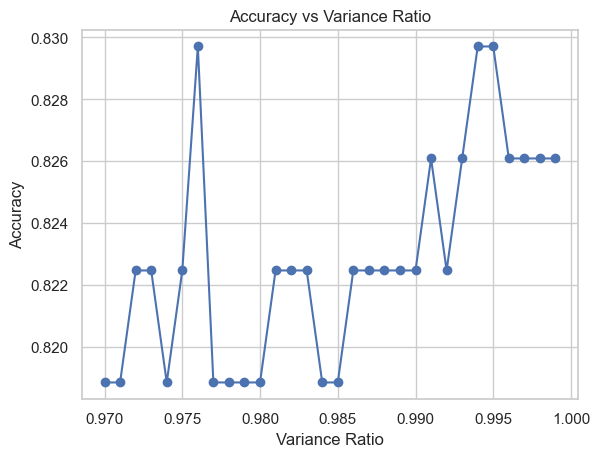

Max Accuracy0.8297101449275363
Number of Features: 149
-------------------
-------------------


In [42]:
c_results, c_params, c_model = svm(complete_input, .2, ['rbf','linear','poly'], [1, 10, 100], [.001, .01, .1])

In [43]:
c_results.sort_values(by='Accuracy', ascending = False)

,Parameters,Accuracy,Weighted Recall,Weighted Precision,Weighted F1 Score,Support,Confusion Matrix
0,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.858696,0.858696,0.864218,0.858113,276.000000,"[[14, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0], ..."
16,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.853225,0.853225,0.853225,0.853225,0.853225,"[[14, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0], ..."
25,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.850514,0.850514,0.850514,0.850514,0.850514,"[[14, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0], ..."
22,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.834200,0.834200,0.834200,0.834200,0.834200,"[[14, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0], ..."
27,"{'C': 100, 'gamma': 0.1, 'kernel': 'poly'}",0.817886,0.817886,0.817886,0.817886,0.817886,"[[14, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0], ..."
26,"{'C': 100, 'gamma': 0.1, 'kernel': 'linear'}",0.807038,0.807038,0.807038,0.807038,0.807038,"[[14, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0], ..."
23,"{'C': 100, 'gamma': 0.01, 'kernel': 'linear'}",0.807038,0.807038,0.807038,0.807038,0.807038,"[[14, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0], ..."
20,"{'C': 100, 'gamma': 0.001, 'kernel': 'linear'}",0.807038,0.807038,0.807038,0.807038,0.807038,"[[14, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0], ..."
5,"{'C': 1, 'gamma': 0.01, 'kernel': 'linear'}",0.807034,0.807034,0.807034,0.807034,0.807034,"[[14, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0], ..."
17,"{'C': 10, 'gamma': 0.1, 'kernel': 'linear'}",0.807034,0.807034,0.807034,0.807034,0.807034,"[[14, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0], ..."


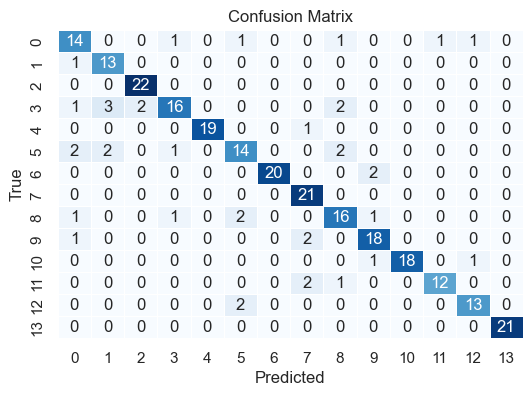

In [44]:
plot_confusion_matrix(c_results, 0)

## GLCM

Generating Texture Features
Start time: 2024-01-17 12:20:48
Elapsed Time: 16.04 seconds
(1380, 33)
Time elapsed: 0 minutes and 16 seconds
----------------------
normalizing
Accuracy: 47.46%
Initial Model Accuracy: 0.4746376811594203
-------------------
-------------------
var: 0.97
(1380, 5)
Accuracy: 0.4528985507246377
var: 0.971
(1380, 5)
Accuracy: 0.4528985507246377
var: 0.972
(1380, 5)
Accuracy: 0.4528985507246377
var: 0.973
(1380, 5)
Accuracy: 0.4528985507246377
var: 0.974
(1380, 5)
Accuracy: 0.4528985507246377
var: 0.975
(1380, 5)
Accuracy: 0.4528985507246377
var: 0.976
(1380, 6)
Accuracy: 0.44565217391304346
var: 0.977
(1380, 6)
Accuracy: 0.44565217391304346
var: 0.978
(1380, 6)
Accuracy: 0.44565217391304346
var: 0.979
(1380, 6)
Accuracy: 0.44565217391304346
var: 0.98
(1380, 6)
Accuracy: 0.44565217391304346
var: 0.981
(1380, 6)
Accuracy: 0.44565217391304346
var: 0.982
(1380, 6)
Accuracy: 0.44565217391304346
var: 0.983
(1380, 6)
Accuracy: 0.44565217391304346
var: 0.984
(1380, 6)


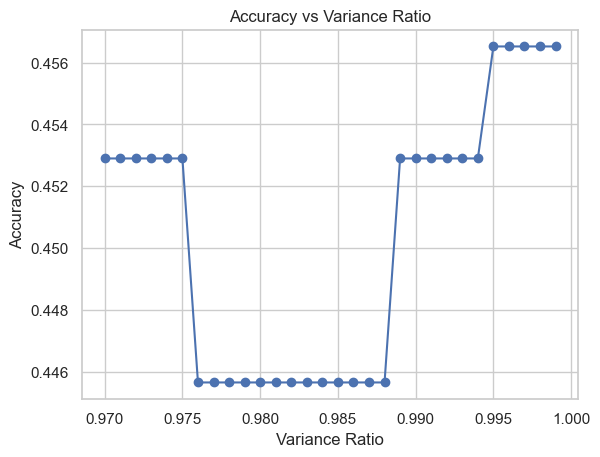

Max Accuracy0.45652173913043476
Number of Features: 8
-------------------
-------------------


,Parameters,Accuracy,Weighted Recall,Weighted Precision,Weighted F1 Score,Support,Confusion Matrix
0,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.597826,0.597826,0.628614,0.585336,276.000000,"[[12, 0, 0, 1, 1, 2, 0, 2, 1, 0, 0, 0, 0, 0], ..."
25,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.590605,0.590605,0.590605,0.590605,0.590605,"[[12, 0, 0, 1, 1, 2, 0, 2, 1, 0, 0, 0, 0, 0], ..."
26,"{'C': 100, 'gamma': 0.1, 'kernel': 'linear'}",0.589696,0.589696,0.589696,0.589696,0.589696,"[[12, 0, 0, 1, 1, 2, 0, 2, 1, 0, 0, 0, 0, 0], ..."
23,"{'C': 100, 'gamma': 0.01, 'kernel': 'linear'}",0.589696,0.589696,0.589696,0.589696,0.589696,"[[12, 0, 0, 1, 1, 2, 0, 2, 1, 0, 0, 0, 0, 0], ..."
20,"{'C': 100, 'gamma': 0.001, 'kernel': 'linear'}",0.589696,0.589696,0.589696,0.589696,0.589696,"[[12, 0, 0, 1, 1, 2, 0, 2, 1, 0, 0, 0, 0, 0], ..."
11,"{'C': 10, 'gamma': 0.001, 'kernel': 'linear'}",0.555265,0.555265,0.555265,0.555265,0.555265,"[[12, 0, 0, 1, 1, 2, 0, 2, 1, 0, 0, 0, 0, 0], ..."
17,"{'C': 10, 'gamma': 0.1, 'kernel': 'linear'}",0.555265,0.555265,0.555265,0.555265,0.555265,"[[12, 0, 0, 1, 1, 2, 0, 2, 1, 0, 0, 0, 0, 0], ..."
14,"{'C': 10, 'gamma': 0.01, 'kernel': 'linear'}",0.555265,0.555265,0.555265,0.555265,0.555265,"[[12, 0, 0, 1, 1, 2, 0, 2, 1, 0, 0, 0, 0, 0], ..."
22,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.488244,0.488244,0.488244,0.488244,0.488244,"[[12, 0, 0, 1, 1, 2, 0, 2, 1, 0, 0, 0, 0, 0], ..."
16,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.487343,0.487343,0.487343,0.487343,0.487343,"[[12, 0, 0, 1, 1, 2, 0, 2, 1, 0, 0, 0, 0, 0], ..."


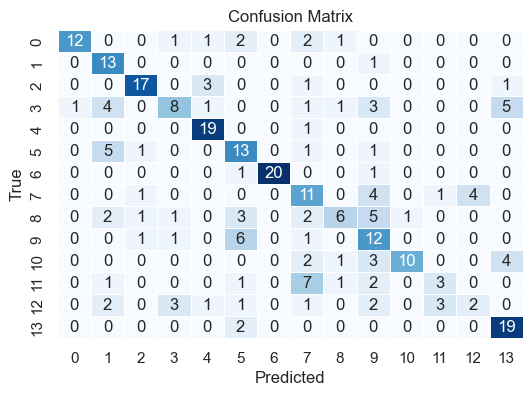

In [45]:
complete_input = complete_feature_extraction(complete_df, 82, 10, 10, ['f_glcm'])
c_results, c_params, c_model = svm(complete_input, .2, ['rbf','linear','poly'], [1, 10, 100], [.001, .01, .1])
display(c_results.sort_values(by='Accuracy', ascending = False))
plot_confusion_matrix(c_results, 0)

## Histogram

Generating Color Histogram Features
Start time: 2024-01-17 12:21:10
(1380, 738)
Time elapsed: 0 minutes and 20 seconds
----------------------
normalizing
Accuracy: 80.43%
Initial Model Accuracy: 0.8043478260869565
-------------------
-------------------
var: 0.97
(1380, 111)
Accuracy: 0.782608695652174
var: 0.971
(1380, 113)
Accuracy: 0.782608695652174
var: 0.972
(1380, 116)
Accuracy: 0.7862318840579711
var: 0.973
(1380, 118)
Accuracy: 0.7898550724637681
var: 0.974
(1380, 120)
Accuracy: 0.7898550724637681
var: 0.975
(1380, 123)
Accuracy: 0.7862318840579711
var: 0.976
(1380, 126)
Accuracy: 0.7862318840579711
var: 0.977
(1380, 129)
Accuracy: 0.7862318840579711
var: 0.978
(1380, 132)
Accuracy: 0.7898550724637681
var: 0.979
(1380, 135)
Accuracy: 0.7898550724637681
var: 0.98
(1380, 138)
Accuracy: 0.7898550724637681
var: 0.981
(1380, 142)
Accuracy: 0.7898550724637681
var: 0.982
(1380, 146)
Accuracy: 0.782608695652174
var: 0.983
(1380, 150)
Accuracy: 0.7753623188405797
var: 0.984
(1380, 154)


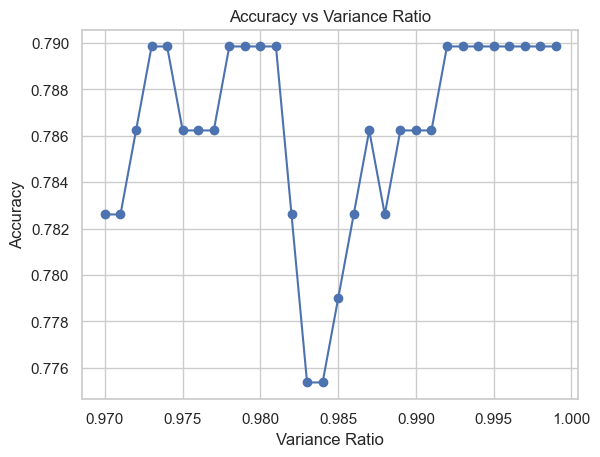

Max Accuracy0.7898550724637681
Number of Features: 118
-------------------
-------------------
                                        Parameters  Accuracy  Weighted Recall  \
16        {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}  0.851415         0.851415   
25       {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}  0.844167         0.844167   
0         {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}  0.836957         0.836957   
22      {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}  0.811571         0.811571   
27      {'C': 100, 'gamma': 0.1, 'kernel': 'poly'}  0.810662         0.810662   
14    {'C': 10, 'gamma': 0.01, 'kernel': 'linear'}  0.804327         0.804327   
17     {'C': 10, 'gamma': 0.1, 'kernel': 'linear'}  0.804327         0.804327   
11   {'C': 10, 'gamma': 0.001, 'kernel': 'linear'}  0.804327         0.804327   
26    {'C': 100, 'gamma': 0.1, 'kernel': 'linear'}  0.803414         0.803414   
23   {'C': 100, 'gamma': 0.01, 'kernel': 'linear'}  0.803414         0.803414   
20  {'C': 100,

None

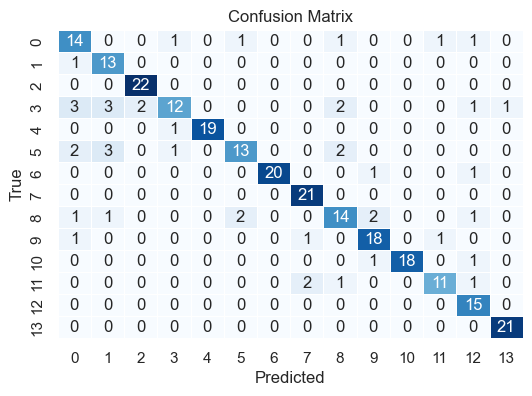

In [46]:
complete_input = complete_feature_extraction(complete_df, 82, 10, 10, ['f_histogram'])
c_results, c_params, c_model = svm(complete_input, .2, ['rbf','linear','poly'], [1, 10, 100], [.001, .01, .1])
display(print(c_results.sort_values(by='Accuracy', ascending = False)))
plot_confusion_matrix(c_results, 0)

## Color Moments

Generating Color Moments Features
Start time: 2024-01-17 12:21:42


C:\Users\isabe\AppData\Local\Temp\ipykernel_18280\4170511435.py:18: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt = vectors.apply(lambda x: kurtosis(x, nan_policy='omit'))
C:\Users\isabe\AppData\Local\Temp\ipykernel_18280\4170511435.py:19: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewness = vectors.apply(lambda x: skew(x, nan_policy='omit'))
C:\Users\isabe\AppData\Local\Temp\ipykernel_18280\4170511435.py:18: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt = vectors.apply(lambda x: kurtosis(x, nan_policy='omit'))
C:\Users\isabe\AppData\Local\Temp\ipykernel_18280\4170511435.py:19: RuntimeWarning: Prec

(1380, 36)
Time elapsed: 0 minutes and 10 seconds
----------------------
normalizing
Accuracy: 45.65%
Initial Model Accuracy: 0.45652173913043476
-------------------
-------------------
var: 0.97
(1380, 8)
Accuracy: 0.4420289855072464
var: 0.971
(1380, 8)
Accuracy: 0.4420289855072464
var: 0.972
(1380, 8)
Accuracy: 0.4420289855072464
var: 0.973
(1380, 8)
Accuracy: 0.4420289855072464
var: 0.974
(1380, 8)
Accuracy: 0.4420289855072464
var: 0.975
(1380, 8)
Accuracy: 0.4420289855072464
var: 0.976
(1380, 9)
Accuracy: 0.4420289855072464
var: 0.977
(1380, 9)
Accuracy: 0.4420289855072464
var: 0.978
(1380, 9)
Accuracy: 0.4420289855072464
var: 0.979
(1380, 9)
Accuracy: 0.4420289855072464
var: 0.98
(1380, 9)
Accuracy: 0.4420289855072464
var: 0.981
(1380, 9)
Accuracy: 0.4420289855072464
var: 0.982
(1380, 9)
Accuracy: 0.4420289855072464
var: 0.983
(1380, 9)
Accuracy: 0.4420289855072464
var: 0.984
(1380, 10)
Accuracy: 0.4601449275362319
var: 0.985
(1380, 10)
Accuracy: 0.4601449275362319
var: 0.986
(13

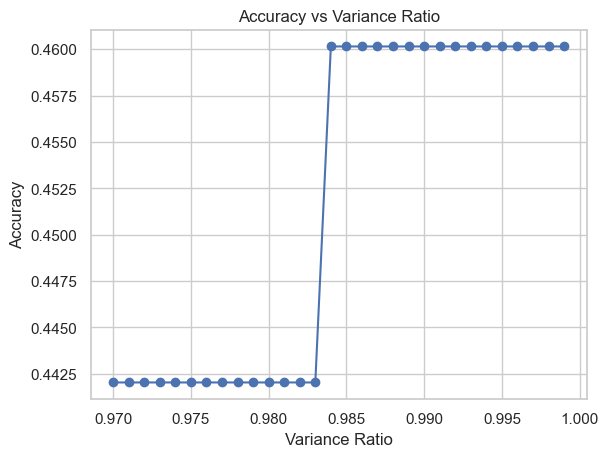

Max Accuracy0.4601449275362319
Number of Features: 10
-------------------
-------------------


,Parameters,Accuracy,Weighted Recall,Weighted Precision,Weighted F1 Score,Support,Confusion Matrix
0,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.557971,0.557971,0.560154,0.540733,276.000000,"[[7, 1, 0, 1, 0, 5, 0, 1, 1, 0, 0, 1, 0, 2], [..."
25,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.534414,0.534414,0.534414,0.534414,0.534414,"[[7, 1, 0, 1, 0, 5, 0, 1, 1, 0, 0, 1, 0, 2], [..."
26,"{'C': 100, 'gamma': 0.1, 'kernel': 'linear'}",0.495487,0.495487,0.495487,0.495487,0.495487,"[[7, 1, 0, 1, 0, 5, 0, 1, 1, 0, 0, 1, 0, 2], [..."
23,"{'C': 100, 'gamma': 0.01, 'kernel': 'linear'}",0.495487,0.495487,0.495487,0.495487,0.495487,"[[7, 1, 0, 1, 0, 5, 0, 1, 1, 0, 0, 1, 0, 2], [..."
20,"{'C': 100, 'gamma': 0.001, 'kernel': 'linear'}",0.495487,0.495487,0.495487,0.495487,0.495487,"[[7, 1, 0, 1, 0, 5, 0, 1, 1, 0, 0, 1, 0, 2], [..."
16,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.480086,0.480086,0.480086,0.480086,0.480086,"[[7, 1, 0, 1, 0, 5, 0, 1, 1, 0, 0, 1, 0, 2], [..."
11,"{'C': 10, 'gamma': 0.001, 'kernel': 'linear'}",0.467404,0.467404,0.467404,0.467404,0.467404,"[[7, 1, 0, 1, 0, 5, 0, 1, 1, 0, 0, 1, 0, 2], [..."
17,"{'C': 10, 'gamma': 0.1, 'kernel': 'linear'}",0.467404,0.467404,0.467404,0.467404,0.467404,"[[7, 1, 0, 1, 0, 5, 0, 1, 1, 0, 0, 1, 0, 2], [..."
14,"{'C': 10, 'gamma': 0.01, 'kernel': 'linear'}",0.467404,0.467404,0.467404,0.467404,0.467404,"[[7, 1, 0, 1, 0, 5, 0, 1, 1, 0, 0, 1, 0, 2], [..."
22,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.452900,0.452900,0.452900,0.452900,0.452900,"[[7, 1, 0, 1, 0, 5, 0, 1, 1, 0, 0, 1, 0, 2], [..."


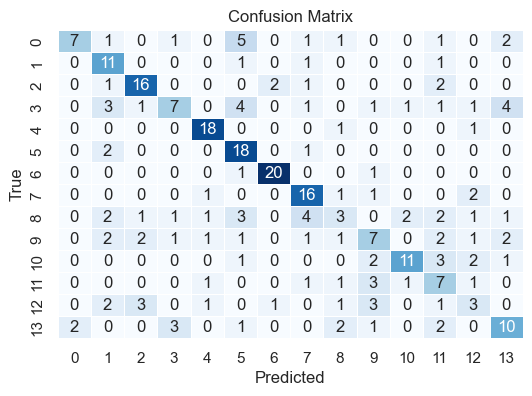

In [47]:
complete_input = complete_feature_extraction(complete_df, 82, 10, 10, ['f_color'])
c_results, c_params, c_model = svm(complete_input, .2, ['rbf','linear','poly'], [1, 10, 100], [.001, .01, .1])
display(c_results.sort_values(by='Accuracy', ascending = False))
plot_confusion_matrix(c_results, 0)

## Zernike

Generating Zernike Features
Start time: 2024-01-17 12:21:58
(1380, 25)
Time elapsed: 0 minutes and 2 seconds
----------------------
normalizing
Accuracy: 10.51%
Initial Model Accuracy: 0.10507246376811594
-------------------
-------------------
var: 0.97
(1380, 22)
Accuracy: 0.10507246376811594
var: 0.971
(1380, 22)
Accuracy: 0.10507246376811594
var: 0.972
(1380, 22)
Accuracy: 0.10507246376811594
var: 0.973
(1380, 22)
Accuracy: 0.10507246376811594
var: 0.974
(1380, 22)
Accuracy: 0.10507246376811594
var: 0.975
(1380, 22)
Accuracy: 0.10507246376811594
var: 0.976
(1380, 22)
Accuracy: 0.10507246376811594
var: 0.977
(1380, 22)
Accuracy: 0.10507246376811594
var: 0.978
(1380, 23)
Accuracy: 0.10144927536231885
var: 0.979
(1380, 23)
Accuracy: 0.10144927536231885
var: 0.98
(1380, 23)
Accuracy: 0.10144927536231885
var: 0.981
(1380, 23)
Accuracy: 0.10144927536231885
var: 0.982
(1380, 23)
Accuracy: 0.10144927536231885
var: 0.983
(1380, 23)
Accuracy: 0.10144927536231885
var: 0.984
(1380, 23)
Accurac

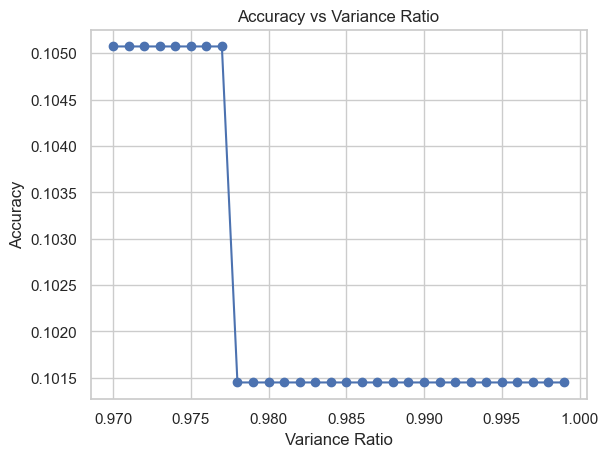

Max Accuracy0.10507246376811594
Number of Features: 22
-------------------
-------------------


C:\Users\isabe\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\isabe\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\isabe\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Parameters,Accuracy,Weighted Recall,Weighted Precision,Weighted F1 Score,Support,Confusion Matrix
16,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.138581,0.138581,0.138581,0.138581,0.138581,"[[1, 2, 0, 1, 2, 2, 1, 0, 0, 0, 1, 0, 0, 9], [..."
0,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.137681,0.137681,0.091800,0.093026,276.000000,"[[1, 2, 0, 1, 2, 2, 1, 0, 0, 0, 1, 0, 0, 9], [..."
25,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.130440,0.130440,0.130440,0.130440,0.130440,"[[1, 2, 0, 1, 2, 2, 1, 0, 0, 0, 1, 0, 0, 9], [..."
26,"{'C': 100, 'gamma': 0.1, 'kernel': 'linear'}",0.125911,0.125911,0.125911,0.125911,0.125911,"[[1, 2, 0, 1, 2, 2, 1, 0, 0, 0, 1, 0, 0, 9], [..."
23,"{'C': 100, 'gamma': 0.01, 'kernel': 'linear'}",0.125911,0.125911,0.125911,0.125911,0.125911,"[[1, 2, 0, 1, 2, 2, 1, 0, 0, 0, 1, 0, 0, 9], [..."
20,"{'C': 100, 'gamma': 0.001, 'kernel': 'linear'}",0.125911,0.125911,0.125911,0.125911,0.125911,"[[1, 2, 0, 1, 2, 2, 1, 0, 0, 0, 1, 0, 0, 9], [..."
2,"{'C': 1, 'gamma': 0.001, 'kernel': 'linear'}",0.125886,0.125886,0.125886,0.125886,0.125886,"[[1, 2, 0, 1, 2, 2, 1, 0, 0, 0, 1, 0, 0, 9], [..."
5,"{'C': 1, 'gamma': 0.01, 'kernel': 'linear'}",0.125886,0.125886,0.125886,0.125886,0.125886,"[[1, 2, 0, 1, 2, 2, 1, 0, 0, 0, 1, 0, 0, 9], [..."
8,"{'C': 1, 'gamma': 0.1, 'kernel': 'linear'}",0.125886,0.125886,0.125886,0.125886,0.125886,"[[1, 2, 0, 1, 2, 2, 1, 0, 0, 0, 1, 0, 0, 9], [..."
22,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.124986,0.124986,0.124986,0.124986,0.124986,"[[1, 2, 0, 1, 2, 2, 1, 0, 0, 0, 1, 0, 0, 9], [..."


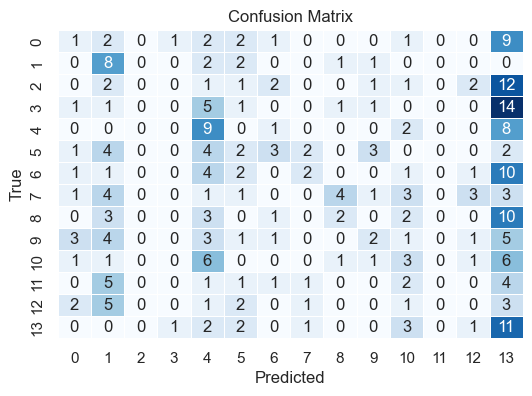

In [48]:
complete_input = complete_feature_extraction(complete_df, 82, 10, 10, ['f_zernike'])
c_results, c_params, c_model = svm(complete_input, .2, ['rbf','linear','poly'], [1, 10, 100], [.001, .01, .1])
display(c_results.sort_values(by='Accuracy', ascending = False))
plot_confusion_matrix(c_results, 0)

## Legendre

Generating Legendre Moments Features
Start time: 2024-01-17 12:22:08
(1380, 121)
Time elapsed: 1 minutes and 10 seconds
----------------------
normalizing
Accuracy: 32.61%
Initial Model Accuracy: 0.32608695652173914
-------------------
-------------------
var: 0.97
(1380, 10)
Accuracy: 0.3079710144927536
var: 0.971
(1380, 10)
Accuracy: 0.3079710144927536
var: 0.972
(1380, 10)
Accuracy: 0.3079710144927536
var: 0.973
(1380, 10)
Accuracy: 0.3079710144927536
var: 0.974
(1380, 10)
Accuracy: 0.3079710144927536
var: 0.975
(1380, 10)
Accuracy: 0.3079710144927536
var: 0.976
(1380, 10)
Accuracy: 0.3079710144927536
var: 0.977
(1380, 10)
Accuracy: 0.3079710144927536
var: 0.978
(1380, 11)
Accuracy: 0.3115942028985507
var: 0.979
(1380, 11)
Accuracy: 0.3115942028985507
var: 0.98
(1380, 11)
Accuracy: 0.3115942028985507
var: 0.981
(1380, 11)
Accuracy: 0.3115942028985507
var: 0.982
(1380, 11)
Accuracy: 0.3115942028985507
var: 0.983
(1380, 11)
Accuracy: 0.3115942028985507
var: 0.984
(1380, 11)
Accuracy: 

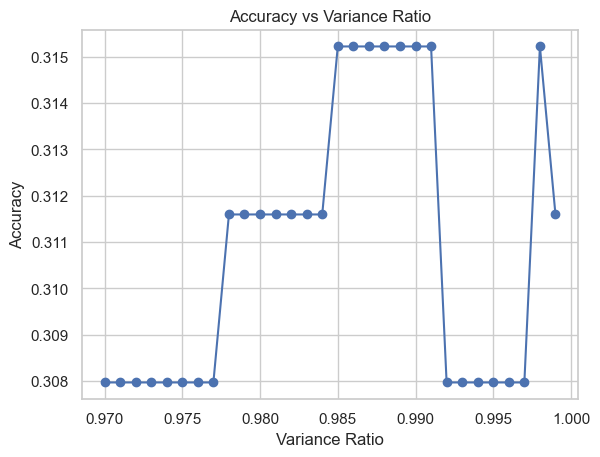

Max Accuracy0.31521739130434784
Number of Features: 12
-------------------
-------------------


,Parameters,Accuracy,Weighted Recall,Weighted Precision,Weighted F1 Score,Support,Confusion Matrix
0,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.413043,0.413043,0.421367,0.392280,276.000000,"[[1, 2, 1, 0, 7, 1, 0, 0, 0, 1, 1, 1, 0, 4], [..."
25,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.384056,0.384056,0.384056,0.384056,0.384056,"[[1, 2, 1, 0, 7, 1, 0, 0, 0, 1, 1, 1, 0, 4], [..."
16,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.373204,0.373204,0.373204,0.373204,0.373204,"[[1, 2, 1, 0, 7, 1, 0, 0, 0, 1, 1, 1, 0, 4], [..."
22,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.333316,0.333316,0.333316,0.333316,0.333316,"[[1, 2, 1, 0, 7, 1, 0, 0, 0, 1, 1, 1, 0, 4], [..."
7,"{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}",0.318824,0.318824,0.318824,0.318824,0.318824,"[[1, 2, 1, 0, 7, 1, 0, 0, 0, 1, 1, 1, 0, 4], [..."
2,"{'C': 1, 'gamma': 0.001, 'kernel': 'linear'}",0.311584,0.311584,0.311584,0.311584,0.311584,"[[1, 2, 1, 0, 7, 1, 0, 0, 0, 1, 1, 1, 0, 4], [..."
5,"{'C': 1, 'gamma': 0.01, 'kernel': 'linear'}",0.311584,0.311584,0.311584,0.311584,0.311584,"[[1, 2, 1, 0, 7, 1, 0, 0, 0, 1, 1, 1, 0, 4], [..."
8,"{'C': 1, 'gamma': 0.1, 'kernel': 'linear'}",0.311584,0.311584,0.311584,0.311584,0.311584,"[[1, 2, 1, 0, 7, 1, 0, 0, 0, 1, 1, 1, 0, 4], [..."
13,"{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}",0.306158,0.306158,0.306158,0.306158,0.306158,"[[1, 2, 1, 0, 7, 1, 0, 0, 0, 1, 1, 1, 0, 4], [..."
19,"{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}",0.298013,0.298013,0.298013,0.298013,0.298013,"[[1, 2, 1, 0, 7, 1, 0, 0, 0, 1, 1, 1, 0, 4], [..."


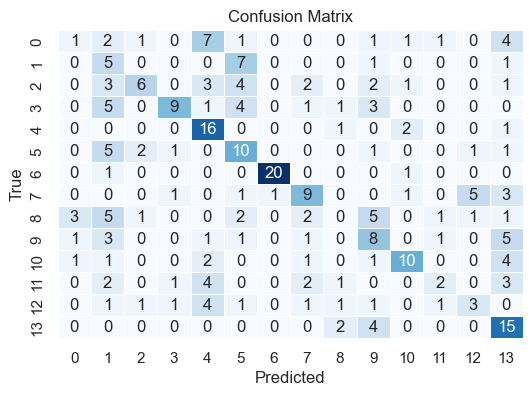

In [49]:
complete_input = complete_feature_extraction(complete_df, 82, 10, 10, ['f_legendre'])
c_results, c_params, c_model = svm(complete_input, .2, ['rbf','linear','poly'], [1, 10, 100], [.001, .01, .1])
display(c_results.sort_values(by='Accuracy', ascending = False))
plot_confusion_matrix(c_results, 0)